In [5]:
# -*- coding: utf-8 -*-

import sys,os
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy import linalg
from numpy import dot
import geomloss as gs


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.autograd import grad
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.nn.modules import Linear
from torch.autograd.functional import jacobian,hessian,vjp,vhp,hvp

import random
import math

FilePath = "../../"
file_list = ['GSM1599494_ES_d0_main.csv', 'GSM1599497_ES_d2_LIFminus.csv', 'GSM1599498_ES_d4_LIFminus.csv', 'GSM1599499_ES_d7_LIFminus.csv']

table_list = []
for filein in file_list:
    table_list.append(pd.read_csv(FilePath+filein, header=None))
matrix_list = []
gene_names = table_list[0].values[:,0]
for table in table_list:
    matrix_list.append(table.values[:,1:].astype('float32'))

cell_counts = [matrix.shape[1] for matrix in matrix_list]

# normalization
def normalize_run(mat):
    rpm = np.sum(mat,0)/1e6
    detect_pr = np.sum(mat==0,0)/float(mat.shape[0])
    return np.log(mat*(np.median(detect_pr)/detect_pr)*1.0/rpm + 1.0)

norm_mat = [normalize_run(matrix) for matrix in matrix_list]

# sort by Wasserstein distance
qt_mat = [np.percentile(norm_in,q=np.linspace(0,100,50),axis=1) for norm_in in norm_mat] 
wdiv=np.sum((qt_mat[0]-qt_mat[3])**2,0)
w_order = np.argsort(-wdiv)

wsub = w_order[0:100]

def nmf(X, latent_features, max_iter=100, error_limit=1e-6, fit_error_limit=1e-6, print_iter=200):
    """
    Decompose X to A*Y
    """
    eps = 1e-5
    print('Starting NMF decomposition with {} latent features and {} iterations.'.format(latent_features, max_iter))
    #X = X.toarray()   I am passing in a scipy sparse matrix

    # mask
    mask = np.sign(X)

    # initial matrices. A is random [0,1] and Y is A\X.
    rows, columns = X.shape
    A = np.random.rand(rows, latent_features)
    A = np.maximum(A, eps)

    Y = linalg.lstsq(A, X)[0]
    Y = np.maximum(Y, eps)

    masked_X = mask * X
    X_est_prev = dot(A, Y)
    for i in range(1, max_iter + 1):
        # ===== updates =====
        # Matlab: A=A.*(((W.*X)*Y')./((W.*(A*Y))*Y'));
        top = dot(masked_X, Y.T)
        bottom = (dot((mask * dot(A, Y)), Y.T)) + eps
        A *= top / bottom

        A = np.maximum(A, eps)
        # print 'A',  np.round(A, 2)

        # Matlab: Y=Y.*((A'*(W.*X))./(A'*(W.*(A*Y))));
        top = dot(A.T, masked_X)
        bottom = dot(A.T, mask * dot(A, Y)) + eps
        Y *= top / bottom
        Y = np.maximum(Y, eps)
        # print 'Y', np.round(Y, 2)


        # ==== evaluation ====
        if i % print_iter == 0 or i == 1 or i == max_iter:
            print('Iteration {}:'.format(i),)
            X_est = dot(A, Y)
            err = mask * (X_est_prev - X_est)
            fit_residual = np.sqrt(np.sum(err ** 2))
            X_est_prev = X_est

            curRes = linalg.norm(mask * (X - X_est), ord='fro')
            print('fit residual', np.round(fit_residual, 4),)
            print('total residual', np.round(curRes, 4))
            if curRes < error_limit or fit_residual < fit_error_limit:
                break
    return A, Y, dot(A,Y)

np.random.seed(0)
norm_imputed = [nmf(normin[wsub,:], latent_features = len(wsub)*4, max_iter=500)[2] for normin in norm_mat]

norm_adj = np.mean(norm_imputed[3],1)[:,np.newaxis]
subvec = np.array([0,1,2,3,4,5,6,7,8,9]) ## the top ten genes

gnvec = gene_names[w_order[subvec]]

cov_mat = np.cov(norm_imputed[3][subvec,:])
whiten = np.diag(np.diag(cov_mat)**(-0.5))
unwhiten = np.diag(np.diag(cov_mat)**(0.5))

norm_imputed2 = [np.dot(whiten,(normin - norm_adj)[subvec,:]) for normin in norm_imputed]

Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 4000.1233
total residual 138.7959
Iteration 200:
fit residual 123.6643
total residual 31.8464
Iteration 400:
fit residual 21.7894
total residual 12.6115
Iteration 500:
fit residual 4.3442
total residual 8.6686
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 2257.8358
total residual 58.2265
Iteration 200:
fit residual 56.8198
total residual 4.0447
Iteration 400:
fit residual 3.4777
total residual 0.6841
Iteration 500:
fit residual 0.3744
total residual 0.3185
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
fit residual 2925.3664
total residual 80.2657
Iteration 200:
fit residual 78.1148
total residual 6.1559
Iteration 400:
fit residual 5.1661
total residual 1.1917
Iteration 500:
fit residual 0.6183
total residual 0.5917
Starting NMF decomposition with 400 latent features and 500 iterations.
Iteration 1:
f

In [6]:
def setup_seed(seed):
     torch.cuda.manual_seed(seed)
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.benchmark=False
     torch.backends.cudnn.deterministic = True
setup_seed(100)

class MLP(nn.Module):

    def __init__(self, dim_in, dim_out, dim_hidden=64, num_hidden=0, activation=nn.Tanh()):
        super(MLP, self).__init__()

        if num_hidden == 0:
            self.linears = nn.ModuleList([nn.Linear(dim_in, dim_out)])
        elif num_hidden >= 1:
            self.linears = nn.ModuleList() 
            self.linears.append(nn.Linear(dim_in, dim_hidden))
            self.linears.extend([nn.Linear(dim_hidden, dim_hidden) for _ in range(num_hidden-1)])
            self.linears.append(nn.Linear(dim_hidden, dim_out))
        else:
            raise Exception('number of hidden layers must be positive')

        for m in self.linears:
            nn.init.xavier_normal_(m.weight)
            nn.init.uniform_(m.bias,a=-0.1,b=0.1)
 
        self.activation = activation 

    def forward(self, x):
        for m in self.linears[:-1]:
            x = self.activation(m(x))

        return self.linears[-1](x)
    
def compute_gradient_penalty(D, real_sample, fake_sample,k,p):
    real_samples = real_sample.requires_grad_(True)
    fake_samples = fake_sample.requires_grad_(True)

    real_validity = D(real_samples)
    fake_validity = D(fake_samples)

    real_grad_out = torch.ones((real_samples.shape[0],1),dtype=torch.float32,requires_grad=False,device="cuda")
    real_grad = grad(
        real_validity, real_samples, real_grad_out, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    real_grad_norm = real_grad.view(real_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

    fake_grad_out = torch.ones((fake_samples.shape[0],1),dtype=torch.float32,requires_grad=False,device="cuda")
    fake_grad = grad(
        fake_validity, fake_samples, fake_grad_out, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    fake_grad_norm = fake_grad.view(fake_grad.size(0), -1).pow(2).sum(1) ** (p / 2)

    return (torch.sum(real_grad_norm) + torch.sum(fake_grad_norm)) * k / (real_sample.shape[0]+fake_sample.shape[0])

# the generator
class JumpEulerForwardCuda(nn.Module):
    def __init__(self,in_features,num_hidden,dim_hidden,step_size):
        super(JumpEulerForwardCuda,self).__init__()

        self.diffusion = nn.Parameter(torch.ones(1))
        self.in_features = in_features
        self.step_size = step_size
        
        self.mu = nn.Parameter(torch.ones(1,in_features))
        self.theta = nn.Parameter(torch.ones(1,in_features))
        
    def drift(self,x):
        return self.theta*(self.mu-x)

    def forward(self,z0,Nsim,steps):

        PopulationPath = torch.empty(size = (Nsim,steps+1,self.in_features),device="cuda")
        PopulationPath[:,0,:] = z0
        state = z0

        for i in range(1,steps+1):
            state = state + self.drift(state)*self.step_size + math.sqrt(self.step_size)*torch.normal(0,1,size=(Nsim,10),device="cuda")*self.diffusion
            PopulationPath[:,i,:] = state
        return PopulationPath

In [7]:
# training data
train_data = norm_imputed2

train0 = torch.tensor(train_data[0],dtype=torch.float32,requires_grad = True,device="cuda").t()
train2 = torch.tensor(train_data[1],dtype=torch.float32,requires_grad = True,device="cuda").t()
train4 = torch.tensor(train_data[2],dtype=torch.float32,requires_grad = True,device="cuda").t()
train7 = torch.tensor(train_data[3],dtype=torch.float32,requires_grad = True,device="cuda").t()


n_sims = train0.shape[0]
in_features = train0.shape[1]

## hyperparameters
step_size = 0.05
lr = 0.0001
k = 2
p = 6
n_steps = [10,20,35]
num_hidden = 3
dim_hidden = 64
    
netG = JumpEulerForwardCuda(10,num_hidden,dim_hidden,step_size).cuda()
netD1 = MLP(10,1,dim_hidden,num_hidden).cuda()
netD2 = MLP(10,1,dim_hidden,num_hidden).cuda()

optimizerG = optim.AdamW(netG.parameters(), lr=lr,weight_decay=0.001)
optimizerSD1 = optim.Adam(netD1.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerSD2 = optim.Adam(netD2.parameters(), lr=lr, betas=(0.5, 0.999))

In [8]:
a=gs.SamplesLoss(loss='sinkhorn',p=2,blur=0.01)

In [9]:
n_epochs = 5000

for epoch in range(n_epochs):
  
    
    # -------------------
    # train the critic
    # -------------------
    

    for _ in range(4):
        fake_data = netG(train0,n_sims,n_steps[2])
        fake1 = fake_data[:,n_steps[0],:]
        fake2 = fake_data[:,n_steps[1],:]

        optimizerSD1.zero_grad()

        div_gp1 = compute_gradient_penalty(netD1,train2,fake1,k,p)
        d1_loss = -torch.mean(netD1(train2))+torch.mean(netD1(fake1))+div_gp1
        d1_loss.backward(retain_graph=True) # retain_graph=True

        optimizerSD1.step()


        optimizerSD2.zero_grad()
        
        div_gp2 = compute_gradient_penalty(netD2,train4,fake2,k,p)
        d2_loss = -torch.mean(netD2(train4))+torch.mean(netD2(fake2))+div_gp2
        d2_loss.backward(retain_graph=True)

        optimizerSD2.step()
        

    # ----------------
    # train the generator
    # ----------------

    
    for _ in range(1):
        optimizerG.zero_grad()
        
        fake_data = netG(train0,n_sims,n_steps[2])
        fake1 = fake_data[:,n_steps[0],:]
        fake2 = fake_data[:,n_steps[1],:]
        g_loss = -torch.mean(netD1(fake1))-torch.mean(netD2(fake2))
        g_loss.backward() 

        optimizerG.step()

    if epoch %10==0:
        print("epoch:",epoch,";", "d1_loss:",(-d1_loss+div_gp1).item(),";","d2_loss:",(-d2_loss+div_gp2).item(),";","g_loss:",g_loss.item())
        print("epoch: ",epoch,"training1: ",a(fake_data[:,n_steps[0],:],train2).item(),"training2: ",a(fake_data[:,n_steps[1],:],train4).item())
    

epoch: 0 ; d1_loss: 0.2597790062427521 ; d2_loss: 0.20044797658920288 ; g_loss: -0.2103591114282608
epoch:  0 training1:  7.6261091232299805 training2:  7.6626129150390625
epoch: 10 ; d1_loss: 0.853905975818634 ; d2_loss: 0.6430175304412842 ; g_loss: -0.19030046463012695
epoch:  10 training1:  7.7050018310546875 training2:  7.655556678771973
epoch: 20 ; d1_loss: 1.2965415716171265 ; d2_loss: 0.9975630640983582 ; g_loss: -0.19187824428081512
epoch:  20 training1:  7.693686485290527 training2:  7.696034908294678
epoch: 30 ; d1_loss: 1.6508594751358032 ; d2_loss: 1.3697952032089233 ; g_loss: 0.20823068916797638
epoch:  30 training1:  7.764264106750488 training2:  7.766146183013916
epoch: 40 ; d1_loss: 1.9359488487243652 ; d2_loss: 1.7985291481018066 ; g_loss: 0.8805667757987976
epoch:  40 training1:  7.742627143859863 training2:  7.680227756500244
epoch: 50 ; d1_loss: 2.2158899307250977 ; d2_loss: 2.1388845443725586 ; g_loss: 1.7696075439453125
epoch:  50 training1:  7.735105991363525 tra

epoch: 490 ; d1_loss: 3.113475799560547 ; d2_loss: 2.853281021118164 ; g_loss: 5.634581565856934
epoch:  490 training1:  7.060632705688477 training2:  7.069519996643066
epoch: 500 ; d1_loss: 3.1781320571899414 ; d2_loss: 2.8379459381103516 ; g_loss: 5.514374732971191
epoch:  500 training1:  7.064513683319092 training2:  6.975462913513184
epoch: 510 ; d1_loss: 3.12211275100708 ; d2_loss: 2.8347532749176025 ; g_loss: 5.557538032531738
epoch:  510 training1:  7.168469429016113 training2:  7.03441858291626
epoch: 520 ; d1_loss: 3.0936574935913086 ; d2_loss: 2.828655958175659 ; g_loss: 5.604368209838867
epoch:  520 training1:  7.0882720947265625 training2:  7.05380916595459
epoch: 530 ; d1_loss: 3.145850419998169 ; d2_loss: 2.8238251209259033 ; g_loss: 5.505797386169434
epoch:  530 training1:  7.127086639404297 training2:  7.040166854858398
epoch: 540 ; d1_loss: 3.136068820953369 ; d2_loss: 2.846972703933716 ; g_loss: 5.434082984924316
epoch:  540 training1:  7.044914245605469 training2:  6

epoch: 980 ; d1_loss: 2.9703569412231445 ; d2_loss: 2.6339635848999023 ; g_loss: 4.705363750457764
epoch:  980 training1:  6.603879928588867 training2:  6.471418857574463
epoch: 990 ; d1_loss: 2.9634780883789062 ; d2_loss: 2.7044754028320312 ; g_loss: 4.631907939910889
epoch:  990 training1:  6.53693151473999 training2:  6.318325996398926
epoch: 1000 ; d1_loss: 2.9584298133850098 ; d2_loss: 2.6827099323272705 ; g_loss: 4.672593593597412
epoch:  1000 training1:  6.659167289733887 training2:  6.472198963165283
epoch: 1010 ; d1_loss: 2.962787389755249 ; d2_loss: 2.6405086517333984 ; g_loss: 4.646045207977295
epoch:  1010 training1:  6.539203643798828 training2:  6.486003875732422
epoch: 1020 ; d1_loss: 2.933187484741211 ; d2_loss: 2.633634328842163 ; g_loss: 4.6573052406311035
epoch:  1020 training1:  6.511927604675293 training2:  6.328950881958008
epoch: 1030 ; d1_loss: 2.9665279388427734 ; d2_loss: 2.6619458198547363 ; g_loss: 4.661552906036377
epoch:  1030 training1:  6.488278865814209

epoch: 1460 ; d1_loss: 2.8104448318481445 ; d2_loss: 2.484703302383423 ; g_loss: 4.449861526489258
epoch:  1460 training1:  6.156223297119141 training2:  6.094563961029053
epoch: 1470 ; d1_loss: 2.783078670501709 ; d2_loss: 2.5185775756835938 ; g_loss: 4.451816082000732
epoch:  1470 training1:  6.139177322387695 training2:  6.041833877563477
epoch: 1480 ; d1_loss: 2.7647178173065186 ; d2_loss: 2.487464427947998 ; g_loss: 4.364583969116211
epoch:  1480 training1:  5.994264602661133 training2:  5.897791862487793
epoch: 1490 ; d1_loss: 2.7889199256896973 ; d2_loss: 2.4776124954223633 ; g_loss: 4.402778148651123
epoch:  1490 training1:  6.087970733642578 training2:  5.855737686157227
epoch: 1500 ; d1_loss: 2.7956736087799072 ; d2_loss: 2.499544143676758 ; g_loss: 4.439054489135742
epoch:  1500 training1:  6.193676948547363 training2:  5.957179069519043
epoch: 1510 ; d1_loss: 2.7843518257141113 ; d2_loss: 2.5095694065093994 ; g_loss: 4.411689758300781
epoch:  1510 training1:  6.006052017211

epoch: 1940 ; d1_loss: 2.6564431190490723 ; d2_loss: 2.3987462520599365 ; g_loss: 4.121189117431641
epoch:  1940 training1:  5.765606880187988 training2:  5.631790637969971
epoch: 1950 ; d1_loss: 2.622617483139038 ; d2_loss: 2.365713119506836 ; g_loss: 4.250802993774414
epoch:  1950 training1:  5.814807891845703 training2:  5.744611740112305
epoch: 1960 ; d1_loss: 2.621682643890381 ; d2_loss: 2.386502981185913 ; g_loss: 4.1662516593933105
epoch:  1960 training1:  5.712881088256836 training2:  5.618821144104004
epoch: 1970 ; d1_loss: 2.6149120330810547 ; d2_loss: 2.4069321155548096 ; g_loss: 4.129123687744141
epoch:  1970 training1:  5.708468914031982 training2:  5.591960906982422
epoch: 1980 ; d1_loss: 2.6089015007019043 ; d2_loss: 2.4033617973327637 ; g_loss: 4.239933967590332
epoch:  1980 training1:  5.797673225402832 training2:  5.660972595214844
epoch: 1990 ; d1_loss: 2.6706323623657227 ; d2_loss: 2.393842935562134 ; g_loss: 4.149190902709961
epoch:  1990 training1:  5.621166229248

epoch: 2420 ; d1_loss: 2.4974374771118164 ; d2_loss: 2.2919976711273193 ; g_loss: 4.105336666107178
epoch:  2420 training1:  5.452208518981934 training2:  5.396267414093018
epoch: 2430 ; d1_loss: 2.495765209197998 ; d2_loss: 2.325471878051758 ; g_loss: 4.085040092468262
epoch:  2430 training1:  5.366547584533691 training2:  5.511570930480957
epoch: 2440 ; d1_loss: 2.4960925579071045 ; d2_loss: 2.295705556869507 ; g_loss: 4.05845308303833
epoch:  2440 training1:  5.273558616638184 training2:  5.365853309631348
epoch: 2450 ; d1_loss: 2.4619741439819336 ; d2_loss: 2.2885050773620605 ; g_loss: 4.096576690673828
epoch:  2450 training1:  5.413357257843018 training2:  5.414403915405273
epoch: 2460 ; d1_loss: 2.4811549186706543 ; d2_loss: 2.313359022140503 ; g_loss: 4.035263538360596
epoch:  2460 training1:  5.240015506744385 training2:  5.43960428237915
epoch: 2470 ; d1_loss: 2.4948763847351074 ; d2_loss: 2.269496202468872 ; g_loss: 4.053474426269531
epoch:  2470 training1:  5.286243438720703

epoch: 2900 ; d1_loss: 2.3615665435791016 ; d2_loss: 2.2751550674438477 ; g_loss: 3.9964818954467773
epoch:  2900 training1:  5.001877784729004 training2:  5.2248735427856445
epoch: 2910 ; d1_loss: 2.341531753540039 ; d2_loss: 2.261739492416382 ; g_loss: 4.050349235534668
epoch:  2910 training1:  5.0227952003479 training2:  5.302401065826416
epoch: 2920 ; d1_loss: 2.3976001739501953 ; d2_loss: 2.2867283821105957 ; g_loss: 4.021190643310547
epoch:  2920 training1:  4.955876350402832 training2:  5.340686798095703
epoch: 2930 ; d1_loss: 2.322521209716797 ; d2_loss: 2.2768616676330566 ; g_loss: 4.096596717834473
epoch:  2930 training1:  5.045213222503662 training2:  5.254609107971191
epoch: 2940 ; d1_loss: 2.3378567695617676 ; d2_loss: 2.2639009952545166 ; g_loss: 4.046506881713867
epoch:  2940 training1:  5.157650947570801 training2:  5.307960510253906
epoch: 2950 ; d1_loss: 2.3600292205810547 ; d2_loss: 2.2952778339385986 ; g_loss: 3.975958824157715
epoch:  2950 training1:  5.01903009414

epoch: 3380 ; d1_loss: 2.2801568508148193 ; d2_loss: 2.2575843334198 ; g_loss: 4.0709333419799805
epoch:  3380 training1:  4.7540202140808105 training2:  5.304125785827637
epoch: 3390 ; d1_loss: 2.233475685119629 ; d2_loss: 2.213150978088379 ; g_loss: 3.9982011318206787
epoch:  3390 training1:  4.651062488555908 training2:  5.095366477966309
epoch: 3400 ; d1_loss: 2.2161097526550293 ; d2_loss: 2.2496702671051025 ; g_loss: 4.0706467628479
epoch:  3400 training1:  4.729183197021484 training2:  5.23617696762085
epoch: 3410 ; d1_loss: 2.26770281791687 ; d2_loss: 2.2559032440185547 ; g_loss: 4.055627822875977
epoch:  3410 training1:  4.712013244628906 training2:  5.154884338378906
epoch: 3420 ; d1_loss: 2.2451388835906982 ; d2_loss: 2.2576560974121094 ; g_loss: 4.037997722625732
epoch:  3420 training1:  4.705763816833496 training2:  5.125384330749512
epoch: 3430 ; d1_loss: 2.2572426795959473 ; d2_loss: 2.242727756500244 ; g_loss: 4.132922172546387
epoch:  3430 training1:  4.752084255218506 

epoch: 3860 ; d1_loss: 2.1973257064819336 ; d2_loss: 2.2547717094421387 ; g_loss: 4.157390594482422
epoch:  3860 training1:  4.447192192077637 training2:  5.221583366394043
epoch: 3870 ; d1_loss: 2.1566343307495117 ; d2_loss: 2.270841121673584 ; g_loss: 4.121013641357422
epoch:  3870 training1:  4.446842193603516 training2:  5.223433494567871
epoch: 3880 ; d1_loss: 2.1920974254608154 ; d2_loss: 2.2799417972564697 ; g_loss: 4.155735492706299
epoch:  3880 training1:  4.47503662109375 training2:  5.296672344207764
epoch: 3890 ; d1_loss: 2.1319420337677 ; d2_loss: 2.2643094062805176 ; g_loss: 4.125059604644775
epoch:  3890 training1:  4.394667625427246 training2:  5.105526924133301
epoch: 3900 ; d1_loss: 2.129680871963501 ; d2_loss: 2.2754015922546387 ; g_loss: 4.15172815322876
epoch:  3900 training1:  4.321634292602539 training2:  5.262845039367676
epoch: 3910 ; d1_loss: 2.1342647075653076 ; d2_loss: 2.2709412574768066 ; g_loss: 4.168956756591797
epoch:  3910 training1:  4.41417932510376 

epoch: 4340 ; d1_loss: 2.0890965461730957 ; d2_loss: 2.235368013381958 ; g_loss: 4.08837366104126
epoch:  4340 training1:  4.205639839172363 training2:  5.234909534454346
epoch: 4350 ; d1_loss: 2.0398247241973877 ; d2_loss: 2.3339176177978516 ; g_loss: 4.169490814208984
epoch:  4350 training1:  4.184250831604004 training2:  5.203883647918701
epoch: 4360 ; d1_loss: 2.079916000366211 ; d2_loss: 2.293623447418213 ; g_loss: 4.1541571617126465
epoch:  4360 training1:  4.118289947509766 training2:  5.326526641845703
epoch: 4370 ; d1_loss: 2.109670639038086 ; d2_loss: 2.2937560081481934 ; g_loss: 4.127646446228027
epoch:  4370 training1:  4.110616207122803 training2:  5.2134599685668945
epoch: 4380 ; d1_loss: 2.051837921142578 ; d2_loss: 2.3066773414611816 ; g_loss: 4.169187068939209
epoch:  4380 training1:  4.133441925048828 training2:  5.209489822387695
epoch: 4390 ; d1_loss: 2.0790438652038574 ; d2_loss: 2.2871856689453125 ; g_loss: 4.2781662940979
epoch:  4390 training1:  4.15906190872192

epoch: 4820 ; d1_loss: 1.999068260192871 ; d2_loss: 2.321950674057007 ; g_loss: 4.389712333679199
epoch:  4820 training1:  3.977508544921875 training2:  5.309755325317383
epoch: 4830 ; d1_loss: 1.982118844985962 ; d2_loss: 2.2957353591918945 ; g_loss: 4.397263526916504
epoch:  4830 training1:  3.8543765544891357 training2:  5.3454999923706055
epoch: 4840 ; d1_loss: 1.9827301502227783 ; d2_loss: 2.3126423358917236 ; g_loss: 4.352389335632324
epoch:  4840 training1:  3.9606552124023438 training2:  5.250185012817383
epoch: 4850 ; d1_loss: 1.9944732189178467 ; d2_loss: 2.3135170936584473 ; g_loss: 4.339530944824219
epoch:  4850 training1:  3.87984561920166 training2:  5.302116394042969
epoch: 4860 ; d1_loss: 1.954599380493164 ; d2_loss: 2.3200957775115967 ; g_loss: 4.317167282104492
epoch:  4860 training1:  3.9534406661987305 training2:  5.283300399780273
epoch: 4870 ; d1_loss: 1.9699794054031372 ; d2_loss: 2.338899612426758 ; g_loss: 4.429067134857178
epoch:  4870 training1:  4.0106048583

In [10]:
torch.save(netG.state_dict(),"./OU_Task2.pt")

tensor(15.7564, device='cuda:0', grad_fn=<SelectBackward>)
1.5617846098318875
1.6333890060866572
2.1321532778273826
0.5934292178087794
1.7571144847221616
2.139037587262207
1.6394444623991082
0.5079120873038403
0.688840157635966
2.2937190609094023


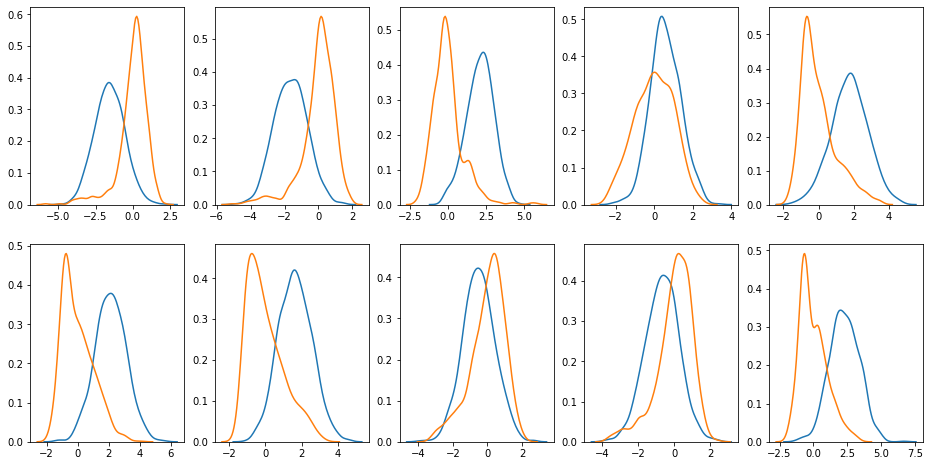

In [11]:
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

setup_seed(305)

path = netG(train0,train0.shape[0],35)
G7 = path[:,-1,:]

print(a(G7,train7))

T4 = train7.detach().cpu().numpy()
G7 = G7.detach().cpu().numpy()

for i in range(10):
    print(scipy.stats.wasserstein_distance(G7[:,i],T7[:,i]))

plt.figure(figsize=(16,8))
plt.subplot(2,5,1)
sns.kdeplot(G7[:,0])
sns.kdeplot(T7[:,0])

plt.subplot(2,5,2)
sns.kdeplot(G7[:,1])
sns.kdeplot(T7[:,1])

plt.subplot(2,5,3)
sns.kdeplot(G7[:,2])
sns.kdeplot(T7[:,2])

plt.subplot(2,5,4)
sns.kdeplot(G7[:,3])
sns.kdeplot(T7[:,3])

plt.subplot(2,5,5)
sns.kdeplot(G7[:,4])
sns.kdeplot(T7[:,4])

plt.subplot(2,5,6)
sns.kdeplot(G7[:,5])
sns.kdeplot(T7[:,5])

plt.subplot(2,5,7)
sns.kdeplot(G7[:,6])
sns.kdeplot(T7[:,6])

plt.subplot(2,5,8)
sns.kdeplot(G7[:,7])
sns.kdeplot(T7[:,7])

plt.subplot(2,5,9)
sns.kdeplot(G7[:,8])
sns.kdeplot(T7[:,8])

plt.subplot(2,5,10)
sns.kdeplot(G7[:,9])
sns.kdeplot(T7[:,9])